## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
from dataclasses import dataclass
from typing import Iterable


## Dataset

In [2]:
class Dataset:
    def __init__(self, xk, yk):
        self.xk = xk
        self.yk = yk
        
    def affichage(self, repere, couleur="red"):
        repere.scatter(self.xk, self.yk, color=couleur, label="échantillon")

## Realite

In [3]:
class Realite:
    def __init__(self, L):
        self.L = L
        
    def __call__(self, xs) -> float:
        return np.sin(10 * np.pi * xs / self.L) / (1 + np.exp(3 * xs / self.L))
    
    def affichage(self, repere, couleur="blue"):
        xs = np.linspace(0, self.L, 500)
        ys = self(xs)
        repere.plot(xs, ys, label="cible", color=couleur)

    def ds_simpliste(self, N: int) -> Dataset:
        xk = np.linspace(0, self.L, N+1)
        yk = self(xk)
        return Dataset(xk=xk, yk=yk)

    def ds_simple(self, N: int, epsilon: float) -> Dataset:
        xk = np.linspace(0, self.L, N+1)
        yk = self(xk) + epsilon * np.random.randn(N+1)
        return Dataset(xk=xk, yk=yk)

    def ds_raisonnable(self, N: int, epsilon: float) -> Dataset:
        xk = np.random.uniform(low=0., high=self.L, size=(N+1, ))
        yk = self(xk) + epsilon * np.random.randn(N+1)
        return Dataset(xk=xk, yk=yk)

## Réseau de Neurones

In [82]:
class RN:
    def __init__(self, n: int):
        self.n = n
        self.alpha = np.zeros(shape=(n, ))
        self.beta = np.zeros(shape=(n, ))
        self.gamma = np.zeros(shape=(n, ))
        self.beta2 = 0.
        
    def sigma(self, z):
        return 1. / (1. + np.exp(-z))
        
    def __repr__(self):
        return f"RN(n={len(self.alpha)})"
        
    def __call__(self, x: np.array) -> np.array:
        if isinstance(x, float):
            x = np.array([x])
        c = self.sigma(np.einsum("k,i->ik", self.alpha , x) + self.beta)
        return self.sigma(np.einsum("k,ik->i", self.gamma, c) + self.beta2)
    
    def reset(self):
        self.alpha = np.zeros(shape=(self.n, ))
        self.beta = np.zeros(shape=(self.n, ))
        self.gamma = np.zeros(shape=(self.n, ))
        self.beta2 = 0.
        
    def aleatoire(self, amplitude=1.0):
        self.alpha = np.random.uniform(low=-amplitude, high=amplitude, size=(self.n, ))
        self.beta = 2.5 * np.ones(shape=(self.n, ))
        self.gamma = np.random.uniform(low=-amplitude, high=amplitude, size=(self.n, ))
        self.beta2 = 0
        
    def affichage(self, repere, couleur="magenta"):
        xg, xd = repere.get_xlim()
        xs = np.linspace(xg, xd, 500)
        ys = self(xs)
        repere.plot(xs, ys, label="prédicteur", color=couleur)
        
    def erreur_quadratique(self, ds: Dataset) -> float:
        return np.sum((self(ds.xk) - ds.yk)**2) / len(ds.xk)
    
    def entrainement(self, ds: Dataset, ftol=1e-08, max_nfev=10_000, debug=False):
        def calcule_residus(cs):
            self.alpha = cs[:self.n]
            self.beta = cs[self.n: 2 * self.n]
            self.gamma = cs[2 * self.n: 3 * self.n ]
            self.beta2 = cs[-1]
            return self(ds.xk) - ds.yk
        
        self.reset()
        opti_result = least_squares(
            fun=calcule_residus,
            x0=np.zeros(shape=(3*self.n+1,)),
            max_nfev=max_nfev,
            ftol=ftol
        )
        if not opti_result.success:
            print("Entrainement Sans succès",)
            print(opti_result.message)
        if debug is True:
            return opti_result
        self.coefficients = opti_result.x

## Score

In [5]:
@dataclass
class Score:
    modele: RN
    score_entrainement: float
    score_selection: float

## Train test split

In [6]:
def train_test_split(ds: Dataset, proportion=0.7) -> tuple[Dataset, Dataset]:
    xtest, ytest, xtrain, ytrain = list(), list(), list(), list()
    for x, y in zip(ds.xk, ds.yk):
        if np.random.random() < proportion:
            xtrain.append(x)
            ytrain.append(y)
        else:
            xtest.append(x)
            ytest.append(y)
    return Dataset(xtrain, ytrain), Dataset(xtest, ytest)

## Validation Croisée

In [7]:
def fusion(dsa: Dataset, dsb: Dataset) -> Dataset:
    xk = list()
    xk.extend(dsa.xk)
    xk.extend(dsb.xk)
    yk = list()
    yk.extend(dsa.yk)
    yk.extend(dsb.yk)    
    return Dataset(xk=xk, yk=yk)
    
def decoupage(ds: Dataset) -> Dataset:
    taille_bloc = len(ds.xk) // 3
    return [
        Dataset(
            xk=ds.xk[: taille_bloc], 
            yk=ds.yk[: taille_bloc]
        ),
        Dataset(
            xk=ds.xk[taille_bloc : 2 * taille_bloc], 
            yk=ds.yk[taille_bloc : 2 * taille_bloc]
        ),
        Dataset(
            xk=ds.xk[2 * taille_bloc :], 
            yk=ds.yk[2 * taille_bloc :]
        ),

    ]

def rotation(ds: Dataset) -> Iterable[tuple[Dataset, Dataset]]:
    ds1, ds2, ds3 = decoupage(ds, nb_parties)
    yield fusion(ds2, ds3), ds1
    yield fusion(ds1, ds3), ds2
    yield fusion(ds1, ds2), ds3

def cross_validation(ds: Dataset, modele: RN) -> Score:
    erreurs_entrainement = list()
    erreurs_selection = list()
    for ds_train, ds_select in rotation(ds):
        modele.entrainement(ds_train)
        erreurs_entrainement.append(modele.erreur_quadratique(ds_train))
        erreurs_selection.append(modele.erreur_quadratique(ds_select))
    return Score(
        modele=modele,
        score_entrainement=sum(erreurs_entrainement) / len(erreurs_entrainement),
        score_selection=sum(erreurs_selection) / len(erreurs_selection),
    )

## Expérimentations

In [8]:
L = 5.
taille_echantillon = 200

reel = Realite(L=L)
ds = reel.ds_raisonnable(N=taille_echantillon, epsilon=0.1)

In [9]:
ds_reste, ds_test = train_test_split(ds, proportion=0.8)

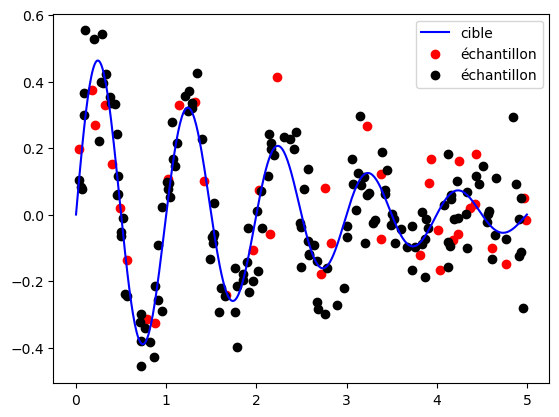

In [10]:
fig, rep = plt.subplots()

reel.affichage(repere=rep)
ds_test.affichage(repere=rep, couleur="red")
ds_reste.affichage(repere=rep, couleur="black")

rep.legend()

In [83]:
rn = RN(n=3)

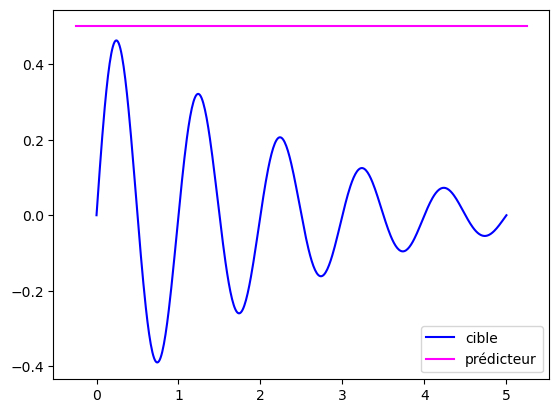

In [80]:
fig, rep = plt.subplots()

reel.affichage(repere=rep, couleur="blue")
rn.affichage(repere=rep, couleur="magenta")

rep.legend()

In [59]:
%%time
rn.entrainement(ds=ds_reste, ftol=1e-08, max_nfev=10_000)

CPU times: total: 1.8 s
Wall time: 335 ms


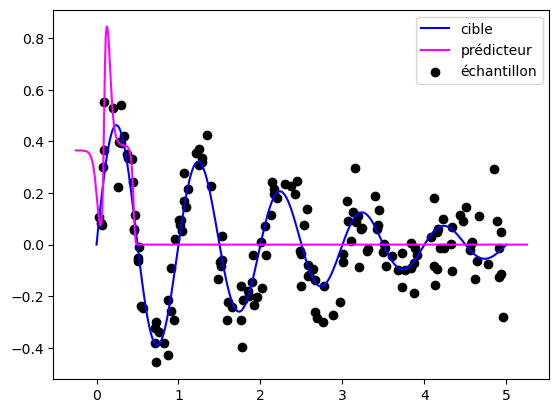

In [60]:
fig, rep = plt.subplots()

reel.affichage(repere=rep, couleur="blue")
rn.affichage(repere=rep, couleur="magenta")
ds_reste.affichage(repere=rep, couleur="black")

rep.legend()

**EXERCICE** comprendre le graphe ci-dessus.

On peut débogguer avec un print pour inspecter la zone d'affichage.
Le problème ne vient pas de là

Calcul de l'erreur quadratique.

In [48]:
rn.erreur_quadratique(ds_reste)

0.029773015701712736

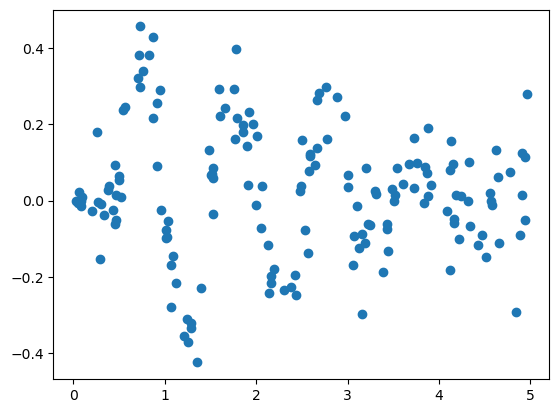

In [49]:
residus = rn(ds_reste.xk) - ds_reste.yk
plt.scatter(ds_reste.xk, residus)

In [50]:
np.mean(residus ** 2)

0.029773015701712736

On joue sur les paramètres du solveur.

In [51]:
%%time
rn.entrainement(ds=ds_reste, ftol=1e-12, max_nfev=10_000)

Entrainement Sans succès
The maximum number of function evaluations is exceeded.
CPU times: total: 50.5 s
Wall time: 8.7 s


In [52]:
%%time
rn.entrainement(ds=ds_reste, ftol=1e-12, max_nfev=100_000)

CPU times: total: 1min 24s
Wall time: 14.4 s


In [53]:
rn.erreur_quadratique(ds_reste)

0.029772861376485896

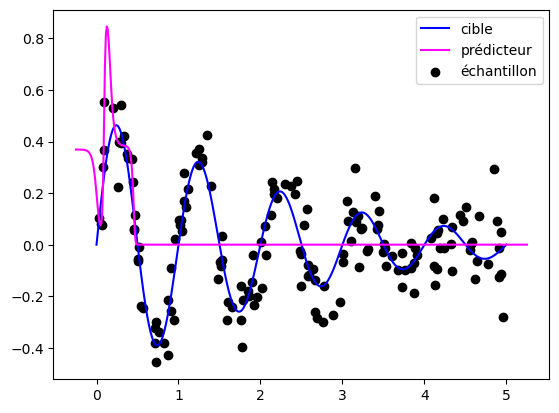

In [54]:
fig, rep = plt.subplots()

reel.affichage(repere=rep, couleur="blue")
rn.affichage(repere=rep, couleur="magenta")
ds_reste.affichage(repere=rep, couleur="black")

rep.legend()

In [61]:
%%time
resultat = rn.entrainement(ds=ds_reste, ftol=1e-12, max_nfev=100_000, debug=True)

CPU times: total: 1min 28s
Wall time: 15.1 s


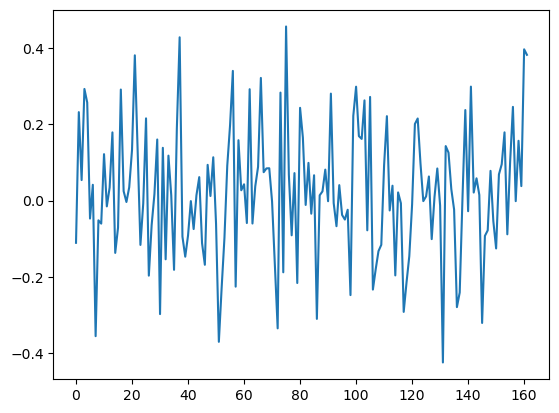

In [63]:
plt.plot(resultat.fun)

In [64]:
resultat.cost

2.411601771495145

Exploration de l'espace des fonctions décrite par le réseau de Neurones.

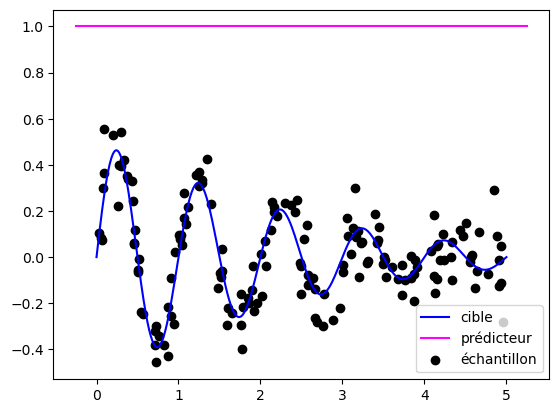

In [72]:
fig, rep = plt.subplots()
reel.affichage(repere=rep, couleur="blue")
rn.aleatoire(amplitude=100.)
rn.affichage(repere=rep, couleur="magenta")
ds_reste.affichage(repere=rep, couleur="black")
rep.legend()

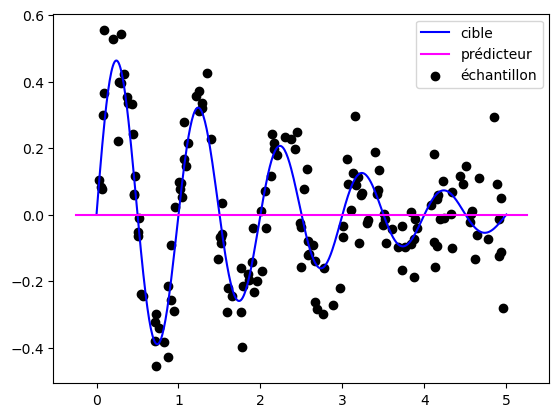

In [73]:
fig, rep = plt.subplots()
reel.affichage(repere=rep, couleur="blue")
rn.aleatoire(amplitude=100.)
rn.affichage(repere=rep, couleur="magenta")
ds_reste.affichage(repere=rep, couleur="black")
rep.legend()

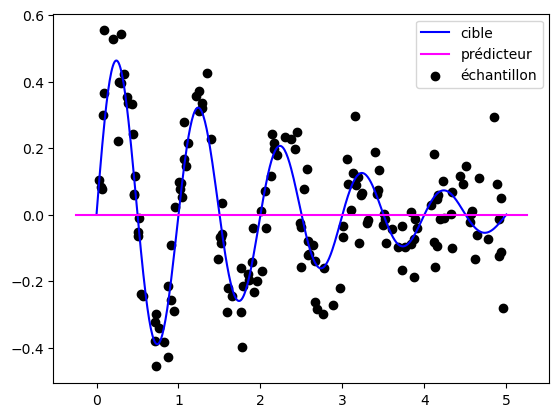

In [74]:
fig, rep = plt.subplots()
reel.affichage(repere=rep, couleur="blue")
rn.aleatoire(amplitude=100.)
rn.affichage(repere=rep, couleur="magenta")
ds_reste.affichage(repere=rep, couleur="black")
rep.legend()

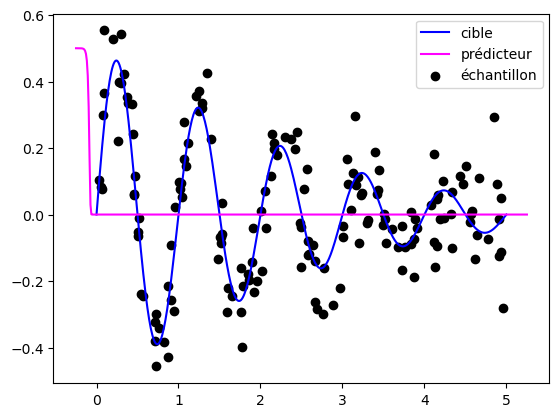

In [114]:
fig, rep = plt.subplots()
reel.affichage(repere=rep, couleur="blue")
rn.aleatoire(amplitude=100.)
rn.affichage(repere=rep, couleur="magenta")
ds_reste.affichage(repere=rep, couleur="black")
rep.legend()

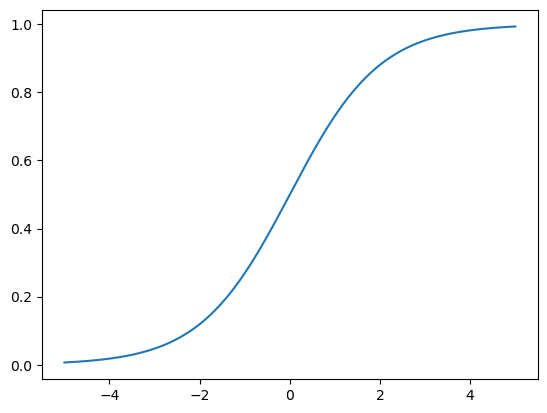

In [90]:
xs = np.linspace(-5., 5., 1000)
ys = rn.sigma(xs)
plt.plot(xs, ys)

$$
\sigma\left( \sum_{i=1}^d \gamma_i \sigma(\alpha_i x + \beta_i) + \beta'\right)
$$

 **Rescaling**
 
 On va appliquer une fonction affine au dataset pour envoyer toutes les abcisses entre 0 et 1.

In [115]:
def rescale(ds: Dataset) -> Dataset:
    return Dataset(
        xk=(ds.xk - np.min(ds.xk)) / (np.max(ds.xk) - np.min(ds.xk)),
        yk=(ds.yk - np.min(ds.yk)) / (np.max(ds.yk) - np.min(ds.yk)),
    )

In [116]:
L = 5.
taille_echantillon = 200

reel = Realite(L=L)
ds = reel.ds_raisonnable(N=taille_echantillon, epsilon=0.1)

In [117]:
ds_rescale = rescale(ds)

In [118]:
ds_train, ds_test = train_test_split(ds_rescale)

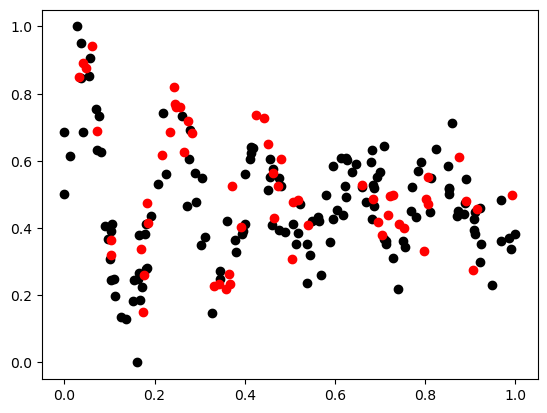

In [120]:
fig, rep = plt.subplots()

ds_train.affichage(rep, couleur="black")
ds_test.affichage(rep, couleur="red")

In [123]:
rn = RN(n=3)
rn.entrainement(ds_train)

fig, rep = plt.subplots()
ds_train.affichage(rep, couleur="black")
ds_test.affichage(rep, couleur="red")
rn.affichage(rep, couleur="magenta")

rep.legend()

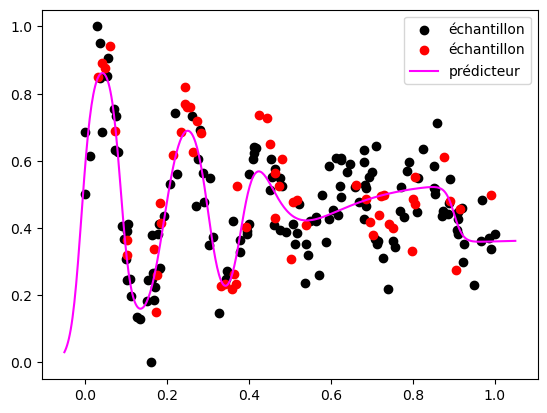

In [124]:
rn = RN(n=5)
rn.entrainement(ds_train)

fig, rep = plt.subplots()
ds_train.affichage(rep, couleur="black")
ds_test.affichage(rep, couleur="red")
rn.affichage(rep, couleur="magenta")

rep.legend()

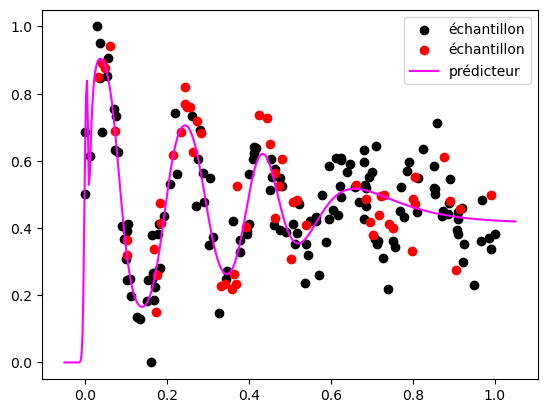

In [126]:
rn = RN(n=6)
rn.entrainement(ds_train, max_nfev=100_000)

fig, rep = plt.subplots()
ds_train.affichage(rep, couleur="black")
ds_test.affichage(rep, couleur="red")
rn.affichage(rep, couleur="magenta")

rep.legend()

## Float

Aller voir [fiche wikipedia](https://en.wikipedia.org/wiki/IEEE_754)

**REMARQUE** les `float` permettent de représenter des nombres invalides et les infinis.

In [21]:
float(3.14)

3.14

In [22]:
# Not a number
float("NaN")

nan

In [23]:
float("inf")

inf

In [24]:
-float("inf")

-inf